In [1]:
!pip install seaborn
!pip install lightgbm
!pip install wordcloud

In [21]:
# Basic Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Preprocessing & Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
)
import lightgbm as lgb

# Optional: For imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Load Sentiment140 dataset
df = pd.read_csv("C:/University/6th/AI/AI Lab/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Simplify target: 0 = negative, 4 = positive → 0 and 1
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
df = df[['text', 'target']]  # Keep only necessary columns

# Preview
print(df.head())


                                                text  target
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...       0
1  is upset that he can't update his Facebook by ...       0
2  @Kenichan I dived many times for the ball. Man...       0
3    my whole body feels itchy and like its on fire        0
4  @nationwideclass no, it's not behaving at all....       0


In [23]:
df.dtypes

text      object
target     int64
dtype: object

In [24]:
df.shape

(1600000, 2)

In [25]:
df.columns

Index(['text', 'target'], dtype='object')

In [26]:
# Load English stopwords
custom_stopwords = set(stopwords.words('english')) - {'no', 'not', 'nor', "don't", "can't"}

# Cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)                  # Remove URLs
    text = re.sub(r"@\w+", "", text)                            # Remove @mentions
    text = re.sub(r"#\w+", "", text)                            # Remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", "", text)                     # Remove special characters & numbers
    text = text.lower()                                         # Convert to lowercase
    text = " ".join(word for word in text.split() if word not in custom_stopwords)  # Remove stopwords
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned text
df[['text', 'clean_text', 'target']].head()


,text,clean_text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day,0
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,0
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds,0
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire,0
4,"@nationwideclass no, it's not behaving at all....",no not behaving im mad cant see,0


In [27]:
# Convert cleaned tweets into numerical features using TF-IDF vectorization (max 5000 features)
from sklearn.feature_extraction.text import TfidfVectorizer

# Limit features to improve speed and avoid memory issues
tfidf = TfidfVectorizer(max_features=5000)

print("Vectorizing tweets...")

# Convert cleaned text into TF-IDF vectors
X = tfidf.fit_transform(df['clean_text'])
y = df['target']  # Labels

# Confirm shape
print(f"\nTF-IDF shape: {X.shape}")  # Should be (1600000, 5000)


Vectorizing tweets...

TF-IDF shape: (1600000, 5000)


In [28]:
# Split the TF-IDF data into training and testing sets with stratified sampling (80/20 split)
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # ensures equal class distribution in train and test
)

# Display shapes
print("Train-Test Split Complete")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Train-Test Split Complete
Training samples: 1280000
Testing samples: 320000


In [29]:
# Initialize LightGBM Classifier
model = lgb.LGBMClassifier(random_state=42)

# Train the model
print("Training LightGBM...")
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

print("Model training complete.")


Training LightGBM...
[LightGBM] [Info] Number of positive: 640000, number of negative: 640000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.256439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 253249
[LightGBM] [Info] Number of data points in the train set: 1280000, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model training complete.


LightGBM Evaluation Metrics:

Accuracy:   0.7521
Precision:  0.7257
Recall:     0.8105
F1 Score:   0.7658


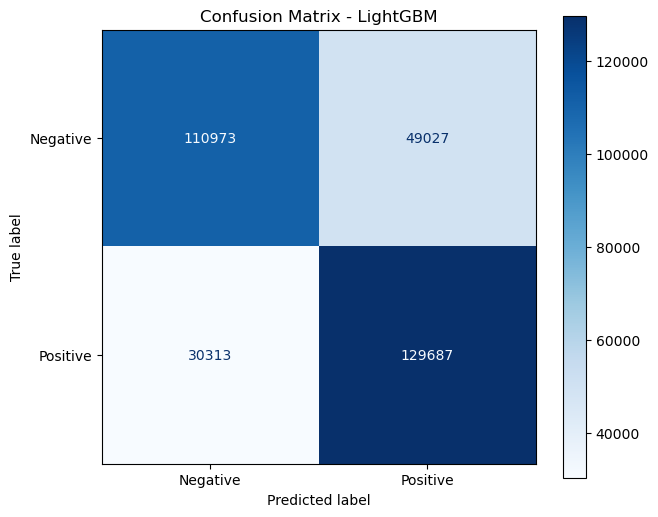

ROC AUC Score: 0.8323
Log Loss:      0.5163


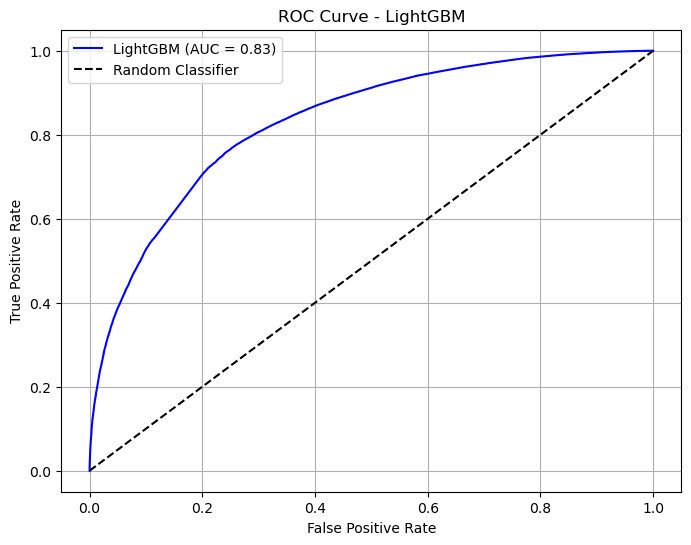

In [30]:
# Evaluate LightGBM model using accuracy, precision, recall, F1, confusion matrix, ROC AUC, and log loss

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, log_loss, roc_curve
)
import matplotlib.pyplot as plt

# Core Evaluation
print("LightGBM Evaluation Metrics:\n")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred):.4f}")
print(f"Recall:     {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:   {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - LightGBM")
plt.grid(False)
plt.show()

# ROC AUC & Log Loss & Curve
try:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_prob)
    logloss = log_loss(y_test, y_pred_prob)
    print(f"ROC AUC Score: {auc:.4f}")
    print(f"Log Loss:      {logloss:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"LightGBM (AUC = {auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()
except AttributeError:
    print("\nModel does not support probability prediction.")


Naive Bayes (MultinomialNB) Evaluation:

Accuracy:   0.7609
Precision:  0.7658
Recall:     0.7518
F1 Score:   0.7587
ROC AUC Score: 0.8450
Log Loss:      0.5157


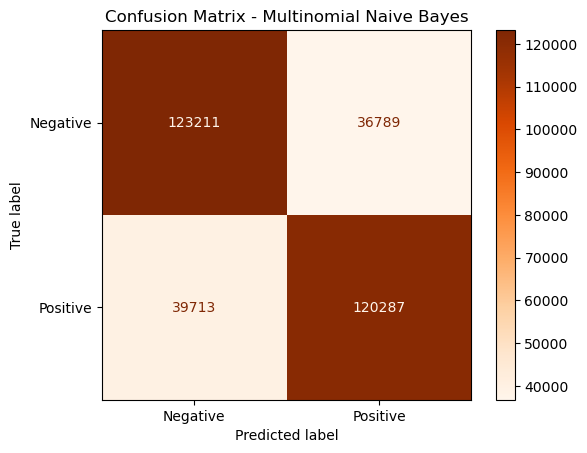

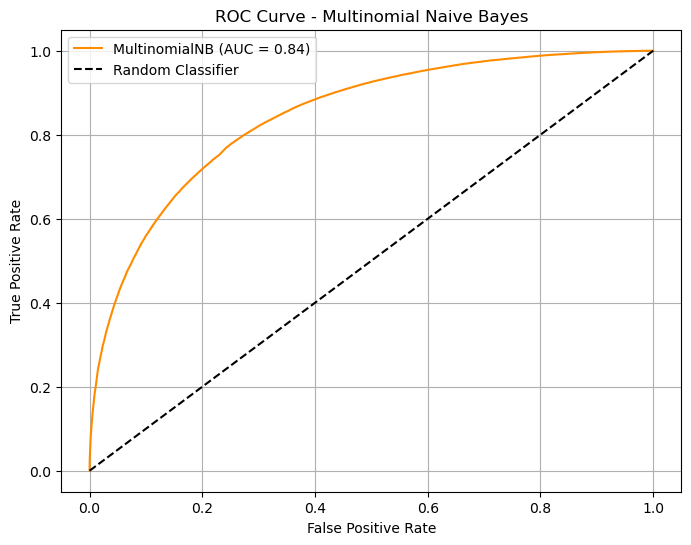

In [31]:
# Comparison with MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, log_loss
)
import matplotlib.pyplot as plt

# Train Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes (MultinomialNB) Evaluation:\n")
print(f"Accuracy:   {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_nb):.4f}")
print(f"Recall:     {recall_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score:   {f1_score(y_test, y_pred_nb):.4f}")

# Log Loss & ROC AUC
y_pred_prob_nb = nb_model.predict_proba(X_test)[:, 1]
roc_auc_nb = roc_auc_score(y_test, y_pred_prob_nb)
logloss_nb = log_loss(y_test, y_pred_prob_nb)

print(f"ROC AUC Score: {roc_auc_nb:.4f}")
print(f"Log Loss:      {logloss_nb:.4f}")

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['Negative', 'Positive'])
disp_nb.plot(cmap='Oranges',values_format = 'd')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.grid(False)
plt.show()

# ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_pred_prob_nb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f"MultinomialNB (AUC = {roc_auc_nb:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multinomial Naive Bayes')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Add tweet length column (number of words per tweet)
df['tweet_length'] = df['text'].apply(lambda x: len(x.split()))


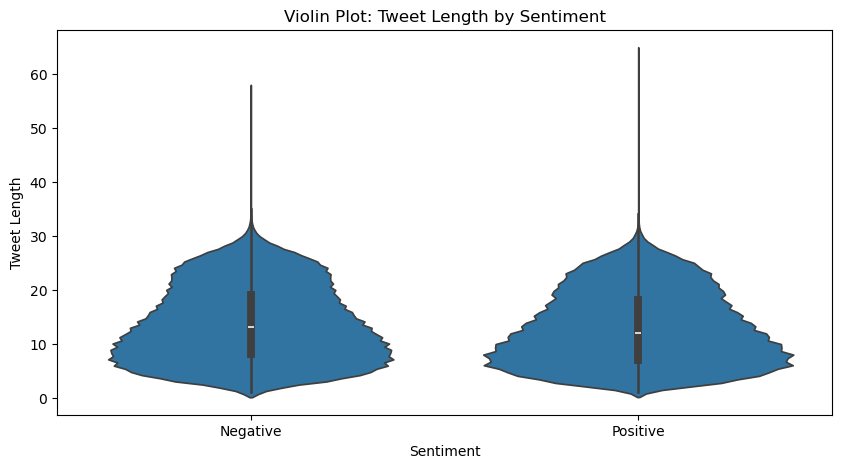

count    1.600000e+06
mean     4.308391e+01
std      2.433203e+01
min      0.000000e+00
25%      2.300000e+01
50%      4.000000e+01
75%      6.100000e+01
max      1.750000e+02
Name: clean_text, dtype: float64


In [33]:
#violin plot displaying tweet length
plt.figure(figsize=(10, 5))
sns.violinplot(x='target', y='tweet_length', data=df)
plt.title("Violin Plot: Tweet Length by Sentiment")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length")
plt.show()
print(df['clean_text'].str.len().describe())

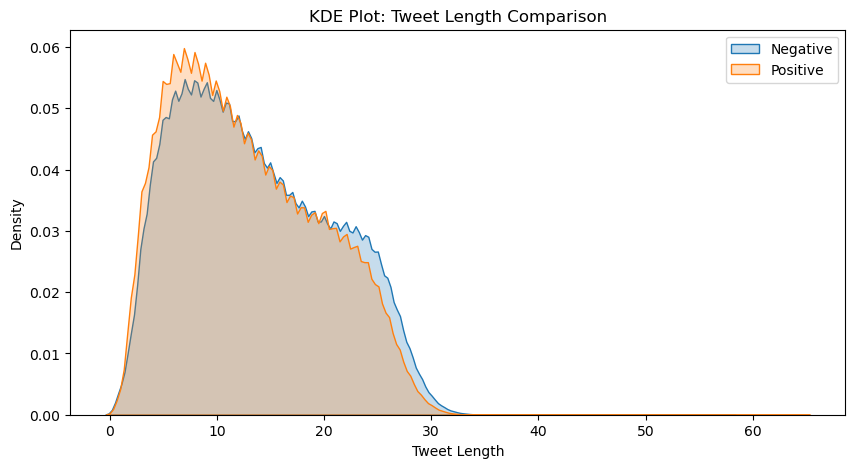

In [34]:
# Plot KDE curves to compare the distribution of tweet lengths for negative and positive sentiments

plt.figure(figsize=(10, 5))
sns.kdeplot(df[df['target'] == 0]['tweet_length'], label='Negative', fill=True)
sns.kdeplot(df[df['target'] == 1]['tweet_length'], label='Positive', fill=True)
plt.title("KDE Plot: Tweet Length Comparison")
plt.xlabel("Tweet Length")
plt.ylabel("Density")
plt.legend()
plt.show()


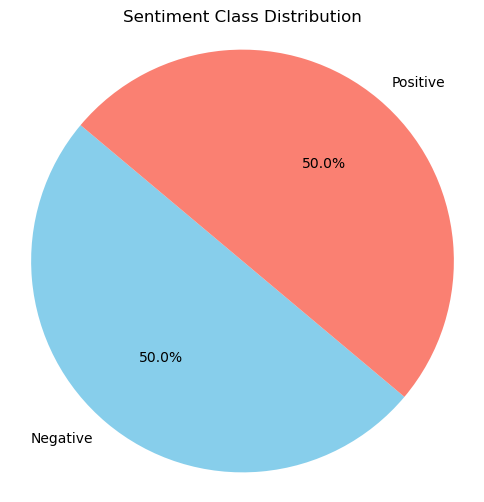

In [35]:
# Display a pie chart showing the distribution of sentiment classes (negative vs. positive)

plt.figure(figsize=(6, 6))
plt.pie(df['target'].value_counts(), labels=['Negative', 'Positive'],
        autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title("Sentiment Class Distribution")
plt.axis('equal')
plt.show()


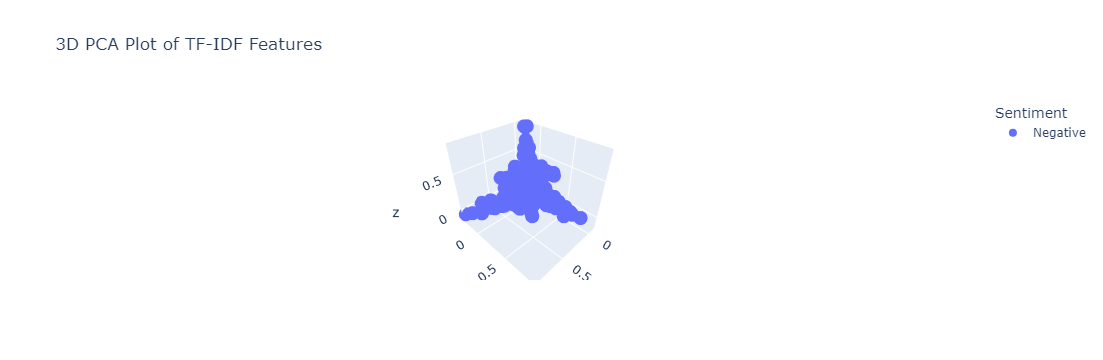

In [39]:
# Perform 3D PCA on a sample of TF-IDF vectors and visualize sentiment separation using a 3D scatter plot

from sklearn.decomposition import PCA
import plotly.express as px

X_dense = X[:5000].toarray()

y_sample = y[:5000]

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_dense)

fig = px.scatter_3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    color=y_sample.map({0: "Negative", 1: "Positive"}),
    title="3D PCA Plot of TF-IDF Features",
    labels={'color': 'Sentiment'}
)
fig.show()


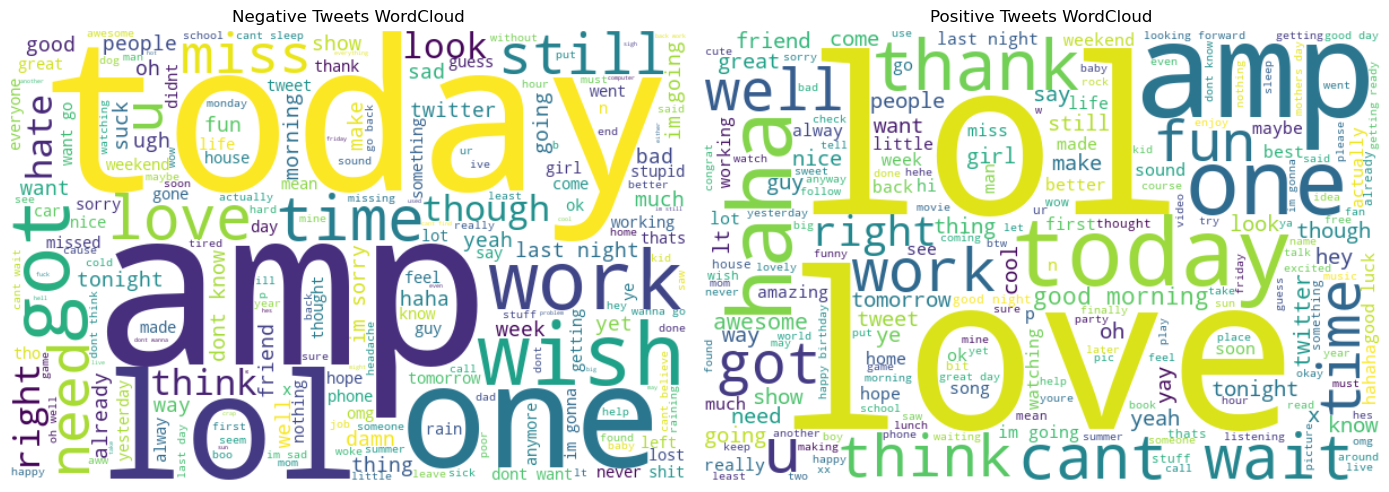

In [37]:
# Generate and display word clouds for negative and positive tweets to visualize frequently used words

from wordcloud import WordCloud

# Separate text by sentiment
neg_text = " ".join(df[df['target'] == 0]['clean_text'].dropna())
pos_text = " ".join(df[df['target'] == 1]['clean_text'].dropna())

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(neg_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Tweets WordCloud")

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=600, height=400, background_color='white').generate(pos_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Tweets WordCloud")

plt.tight_layout()
plt.show()


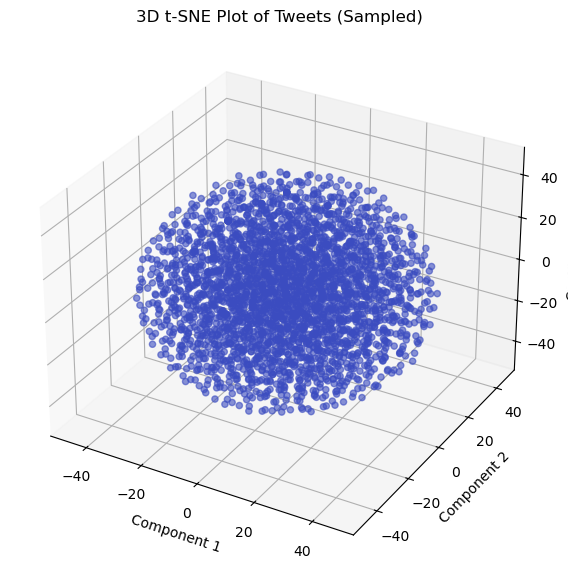

In [38]:
# Apply 3D t-SNE on a sample of TF-IDF vectors and plot the tweet embeddings colored by sentiment

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Limit to 3,000 rows for performance
X_sample = X[:3000]
y_sample = y[:3000]

tsne = TSNE(n_components=3, random_state=42, perplexity=40)
X_tsne = tsne.fit_transform(X_sample.toarray())

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
           c=y_sample, cmap='coolwarm', s=20, alpha=0.6)

ax.set_title('3D t-SNE Plot of Tweets (Sampled)')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()
